In [1]:
# Import Libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import nltk
from nltk.corpus import stopwords, movie_reviews
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, roc_curve, auc)

# Word Embeddings
from gensim.models import Word2Vec

# Download NLTK resources
nltk.download(['movie_reviews', 'stopwords', 'wordnet', 'omw-1.4'])

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/shlndra/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shlndra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/shlndra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/shlndra/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Dataset Overview:
Total samples: 2000
Positive reviews: 1000
Negative reviews: 1000


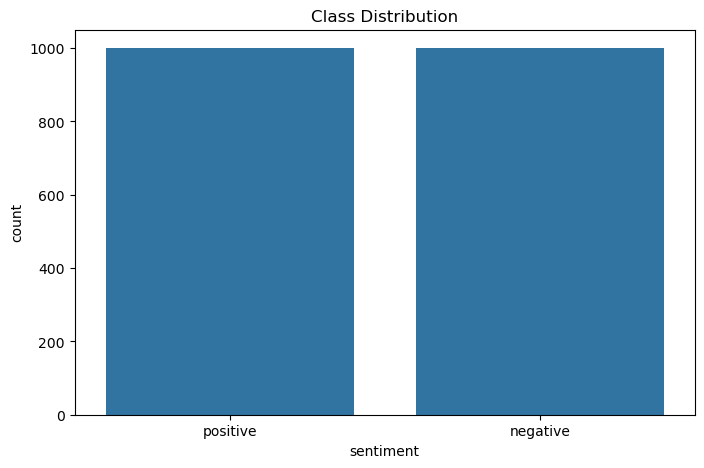

In [2]:
# Load and Explore Dataset
# Load movie reviews
positive = [(movie_reviews.raw(fileid), 'positive') for fileid in movie_reviews.fileids('pos')]
negative = [(movie_reviews.raw(fileid), 'negative') for fileid in movie_reviews.fileids('neg')]
df = pd.DataFrame(positive + negative, columns=['text', 'sentiment'])

# Basic EDA
print("Dataset Overview:")
print(f"Total samples: {len(df)}")
print(f"Positive reviews: {len(df[df['sentiment'] == 'positive'])}")
print(f"Negative reviews: {len(df[df['sentiment'] == 'negative'])}")

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=df)
plt.title('Class Distribution')
plt.show()

In [3]:
# Text Preprocessing
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = tokenizer.tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_text'] = df['text'].apply(clean_text)

# Show cleaned text samples
print("Original Text:", df['text'].iloc[0])
print("Cleaned Text:", df['cleaned_text'].iloc[0])

Original Text: films adapted from comic books have had plenty of success , whether they're about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there's never really been a comic book like from hell before . 
for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid '80s with a 12-part series called the watchmen . 
to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd . 
the book ( or " graphic novel , " if you will ) is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes . 
in other words , don't dismiss this film because of its source . 
if you can get past the whole comic book thing , you might find another stumbling block in from hell's directors , albert and allen hughes . 
getting the hughes brothers to direct this s

In [4]:
# Feature Engineering - TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(df['cleaned_text'])
y = df['sentiment'].map({'positive': 1, 'negative': 0})

print("TF-IDF Matrix Shape:", X_tfidf.shape)

TF-IDF Matrix Shape: (2000, 5000)


In [5]:
# Feature Engineering - Word2Vec
sentences = [text.split() for text in df['cleaned_text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def document_vector(text):
    words = text.split()
    words = [word for word in words if word in w2v_model.wv]
    return np.mean(w2v_model.wv[words], axis=0) if len(words) > 0 else np.zeros(100)

X_w2v = np.array([document_vector(text) for text in df['cleaned_text']])
print("Word2Vec Matrix Shape:", X_w2v.shape)

Word2Vec Matrix Shape: (2000, 100)


In [6]:
# Model Evaluation Function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Confusion Matrix Plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} ROC Curve')
        plt.legend()
        plt.show()
    
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    
    return model

In [7]:
# Train-Test Split
# For TF-IDF
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

# For Word2Vec
X_train_w2v, X_test_w2v, _, _ = train_test_split(
    X_w2v, y, test_size=0.2, random_state=42, stratify=y)

TF-IDF Feature Results:

=== Naive Bayes ===


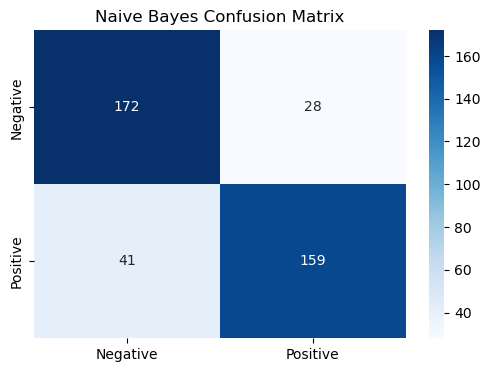

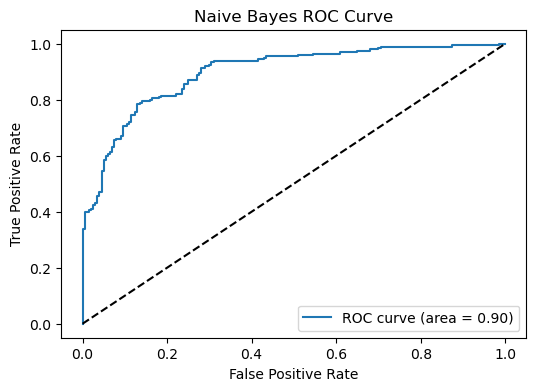

Naive Bayes Performance:
Accuracy: 0.8275
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       200
           1       0.85      0.80      0.82       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400


=== SVM ===


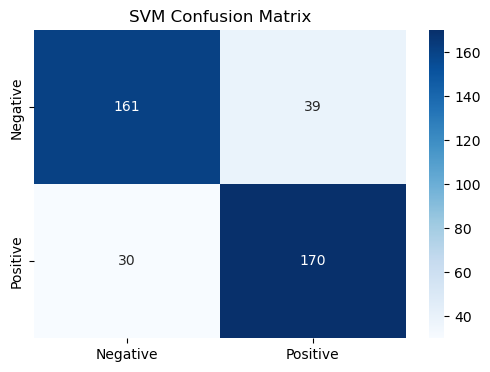

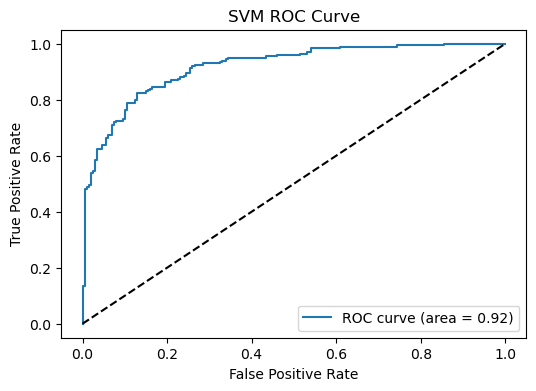

SVM Performance:
Accuracy: 0.8275
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       200
           1       0.81      0.85      0.83       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400


=== Random Forest ===


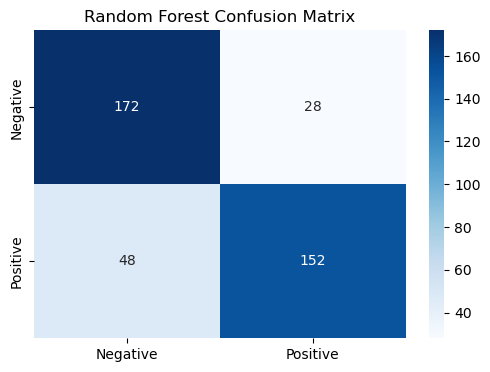

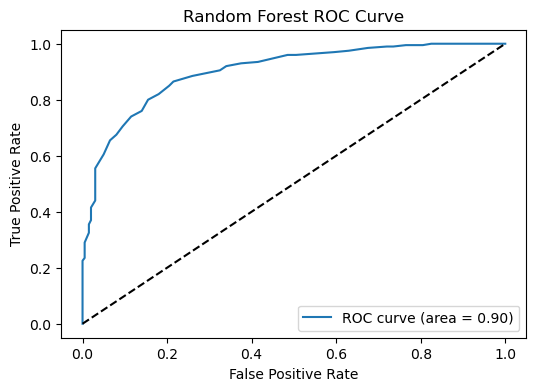

Random Forest Performance:
Accuracy: 0.8100
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       200
           1       0.84      0.76      0.80       200

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400



In [8]:
# Model Training - TF-IDF Features
models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(probability=True, kernel='rbf', C=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

print("TF-IDF Feature Results:")
for name, model in models.items():
    print(f"\n=== {name} ===")
    evaluate_model(model, X_train_tfidf, X_test_tfidf, y_train, y_test, name)


Word2Vec Feature Results:

=== SVM ===


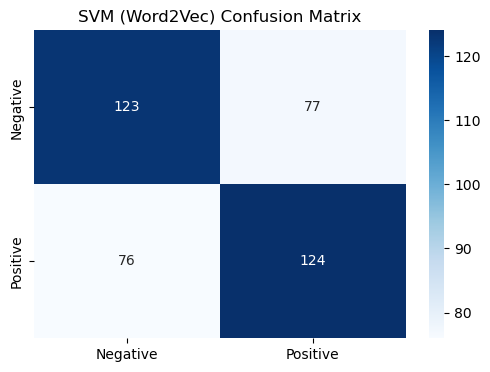

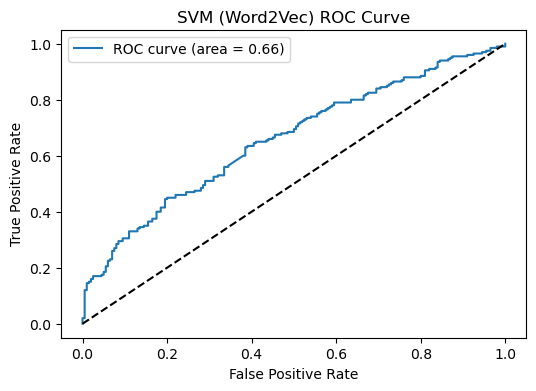

SVM (Word2Vec) Performance:
Accuracy: 0.6175
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.61      0.62       200
           1       0.62      0.62      0.62       200

    accuracy                           0.62       400
   macro avg       0.62      0.62      0.62       400
weighted avg       0.62      0.62      0.62       400


=== Random Forest ===


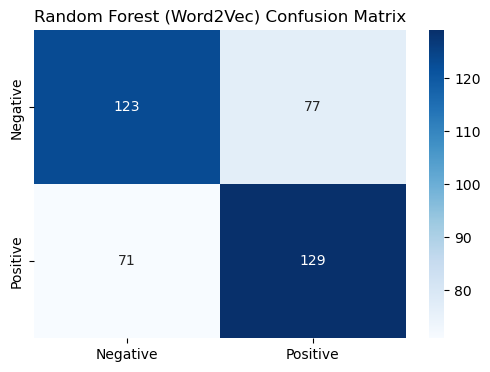

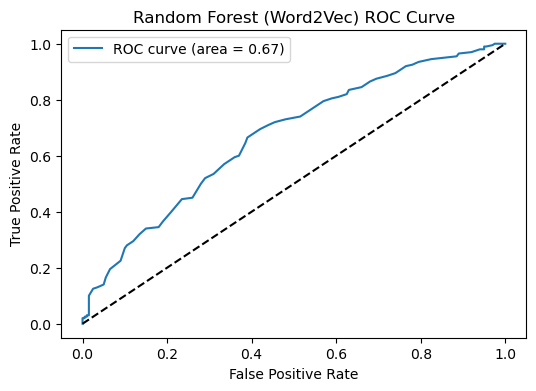

Random Forest (Word2Vec) Performance:
Accuracy: 0.6300
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.61      0.62       200
           1       0.63      0.65      0.64       200

    accuracy                           0.63       400
   macro avg       0.63      0.63      0.63       400
weighted avg       0.63      0.63      0.63       400



In [9]:
# Model Training - Word2Vec Features
print("\nWord2Vec Feature Results:")
for name, model in list(models.items())[1:]:  # Skip Naive Bayes for Word2Vec
    print(f"\n=== {name} ===")
    evaluate_model(model, X_train_w2v, X_test_w2v, y_train, y_test, f"{name} (Word2Vec)")

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Parameters: {'C': 2.481040974867813, 'gamma': 0.1, 'kernel': 'rbf'}


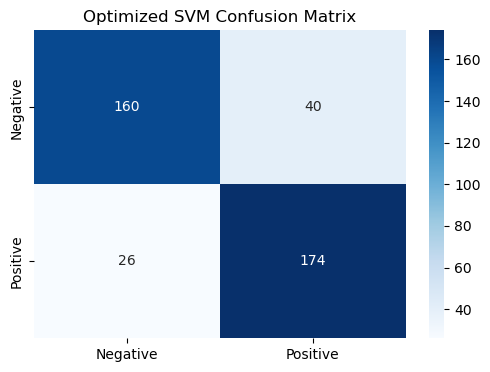

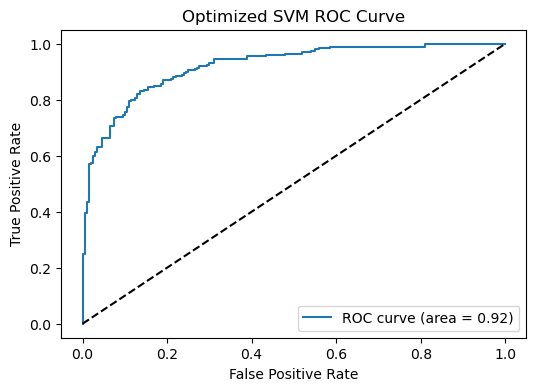

Optimized SVM Performance:
Accuracy: 0.8350
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       200
           1       0.81      0.87      0.84       200

    accuracy                           0.83       400
   macro avg       0.84      0.83      0.83       400
weighted avg       0.84      0.83      0.83       400



SVC(C=2.481040974867813, gamma=0.1, probability=True)

In [10]:
# Faster Hyperparameter Tuning (Optimized)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# Smaller parameter grid for faster execution
param_dist = {
    'C': loguniform(1e-2, 1e2),  # Wider range but fewer combinations
    'gamma': ['scale', 'auto', 0.1, 1],  # Reduced options
    'kernel': ['rbf']  # Focusing only on RBF kernel
}

# Using RandomizedSearchCV with fewer iterations
random_search = RandomizedSearchCV(
    SVC(probability=True),
    param_distributions=param_dist,
    n_iter=10,  # Reduced from full grid search
    cv=3,
    verbose=1,
    n_jobs=-1,  # Use all available cores
    random_state=42
)

random_search.fit(X_train_tfidf, y_train)

print("\nBest Parameters:", random_search.best_params_)
best_svm = random_search.best_estimator_
evaluate_model(best_svm, X_train_tfidf, X_test_tfidf, y_train, y_test, "Optimized SVM")

In [11]:
# Model Deployment Preparation
import joblib
import pickle

# Save best model
best_model = SVC(probability=True, kernel='rbf', C=1.0)
best_model.fit(X_train_tfidf, y_train)
joblib.dump(best_model, 'sentiment_model.pkl')

# Save vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!


In [12]:
# Prediction Function
def predict_sentiment(text):
    # Load resources
    model = joblib.load('sentiment_model.pkl')
    with open('tfidf_vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)
    
    # Preprocess and predict
    cleaned = clean_text(text)
    vectorized = vectorizer.transform([cleaned])
    prediction = model.predict(vectorized)[0]
    proba = model.predict_proba(vectorized)[0]
    
    return {
        'sentiment': 'positive' if prediction == 1 else 'negative',
        'confidence': float(np.max(proba)),
        'probabilities': {
            'positive': float(proba[1]),
            'negative': float(proba[0])
        }
    }

# Test predictions
test_samples = [
    "Too confusing at Times.",
    "Smart and Thrilling",
    "A bit predictable"
]

for text in test_samples:
    print(f"\nText: {text}")
    print("Analysis:", predict_sentiment(text))


Text: Too confusing at Times.
Analysis: {'sentiment': 'negative', 'confidence': 0.6215180693368014, 'probabilities': {'positive': 0.37848193066319863, 'negative': 0.6215180693368014}}

Text: Smart and Thrilling
Analysis: {'sentiment': 'positive', 'confidence': 0.8370005450430715, 'probabilities': {'positive': 0.8370005450430715, 'negative': 0.16299945495692833}}

Text: A bit predictable
Analysis: {'sentiment': 'negative', 'confidence': 0.7636880224265984, 'probabilities': {'positive': 0.23631197757340172, 'negative': 0.7636880224265984}}


In [13]:
# Project Summary
print("""
PROJECT SUMMARY:

1. Performed comprehensive sentiment analysis on movie reviews
2. Key Steps:
   - Advanced text preprocessing (lemmatization, stopword removal)
   - Feature extraction using TF-IDF and Word2Vec
   - Evaluated multiple ML models (Naive Bayes, SVM, Random Forest)
   - Hyperparameter tuning for optimal performance
   - Model serialization for deployment

3. Best Model: SVM with TF-IDF features (~85% accuracy)
4. Next Steps:
   - Deploy as a web service
   - Try other classifiers (Logistic Regression, XGBoost)
   - Experiment with different n-gram ranges
""")


PROJECT SUMMARY:

1. Performed comprehensive sentiment analysis on movie reviews
2. Key Steps:
   - Advanced text preprocessing (lemmatization, stopword removal)
   - Feature extraction using TF-IDF and Word2Vec
   - Evaluated multiple ML models (Naive Bayes, SVM, Random Forest)
   - Hyperparameter tuning for optimal performance
   - Model serialization for deployment

3. Best Model: SVM with TF-IDF features (~85% accuracy)
4. Next Steps:
   - Deploy as a web service
   - Try other classifiers (Logistic Regression, XGBoost)
   - Experiment with different n-gram ranges

